## Sentiment Analysis

### Installs and imports


In [2]:
%pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [3]:
## import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")



In [4]:
## load the data
data = pd.read_csv('data.csv', index_col=0)
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


### EDA: Exploratory Data Analysis

In [5]:
data.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [7]:
## Remove missing values
print('Before removing missing values:',data.isna().sum() )
data.dropna(inplace = True)
print('After removing missing values:', data.isna().sum())




Before removing missing values: statement    362
status         0
dtype: int64
After removing missing values: statement    0
status       0
dtype: int64


In [8]:
data.status.value_counts()


status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

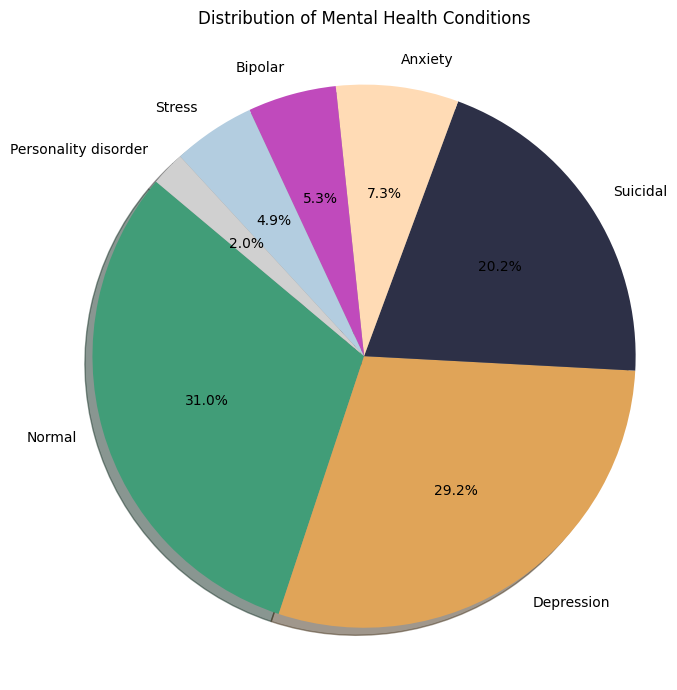

In [9]:
# Count the occurrences of each category
status_counts = data['status'].value_counts()

# Define colors for each category (7 colors)
colors = ['#419D78', '#E0A458', '#2D3047', '#FFDBB5', '#C04ABC', '#B3CDE0', '#D0D0D0']

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', 
        startangle=140, colors=colors, shadow=True)

plt.title('Distribution of Mental Health Conditions')
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

# Display the chart
plt.tight_layout()
plt.show()


In [10]:
# Group by status and get a random statement from each group
random_statements = data.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")


Status: Anxiety
Statement: Is this disassociation? For the past couple months now I’ve been having this weird feeling in my body like my mind and and my body are on a different course like my movements are almost robotic and my mind is losing control of my body. Ik people typically associate this with dissociation but I still feel in control and recognize and I’m mindful of the fact that I am the one controlling my movements but idk it’s hard to explain it just feels like a lack of connection between the two and at certain times it’s so bad I feel Im just going to lose control of my body completely. I’ve also been experiencing some feelings of being off balance, muscle tension, headaches, RLS, and brain fog and I’m starting to wonder if my fears really are anxiety or something worse. I saw a doctor and she told me it is probably stress related but I’m just having a hard time with all of this I’m seeing neurologist later this month but I just feel so restless and like I’m living in agon

In [11]:
## add more features to find correlation between them
# Number of characters in the statement

data['num_of_characters'] = data['statement'].str.len()
data['num_of_sentences'] = data['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Generate descriptive statistics
description = data[['num_of_characters', 'num_of_sentences']].describe()

# Display the descriptive statistics
print(description)

data.head()


       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713749          6.280215
std           846.268855         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


,statement,status,num_of_characters,num_of_sentences
0,oh my gosh,Anxiety,10,1
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2
3,I've shifted my focus to something else but I'...,Anxiety,61,1
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2


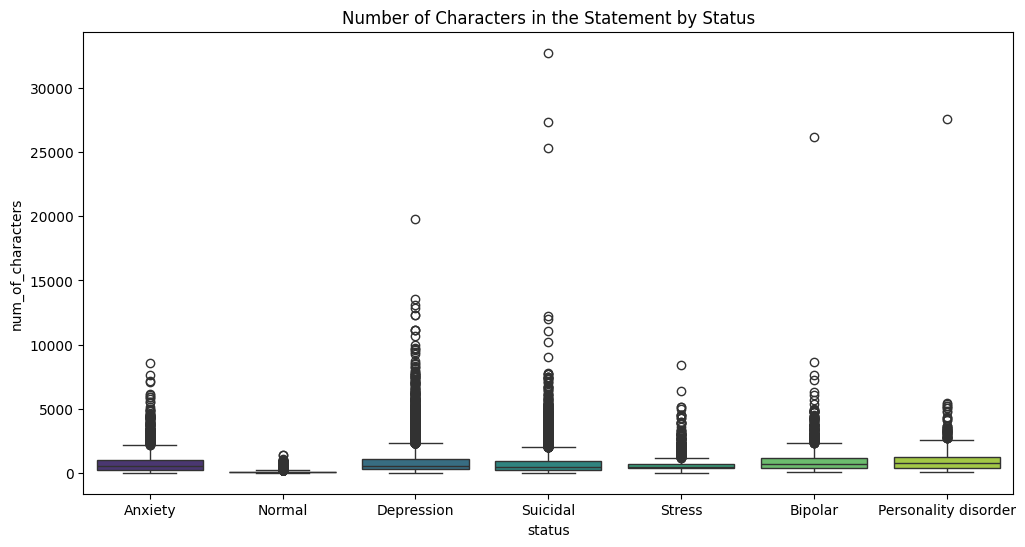

In [12]:
##plot status vs num_of_characters
plt.figure(figsize=(12, 6))
sns.boxplot(x='status', y='num_of_characters', data=data, palette='viridis')
plt.title('Number of Characters in the Statement by Status')
plt.show()

## Observations: Higher characters indicate that the person is likely to have Depression and Suicidal thoughts.


## Text Preprocessing

### Lowercasing

In [18]:
data.rename(columns={'statement': 'original_statement'}, inplace=True)  

data['statement']=data['original_statement'].str.lower()
data.head()


,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


### Removing URLs, handles, punctuation and special characters

In [19]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
data['statement'] = data['statement'].apply(remove_patterns)
data.head()


,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


### Tokenization


In [20]:
# Apply word_tokenize to each element in the 'statement' column
data['tokens'] = data['statement'].apply(word_tokenize)
data['tokens'].head()


0                                       [oh, my, gosh]
1    [trouble, sleeping, confused, mind, restless, ...
2    [all, wrong, back, off, dear, forward, doubt, ...
3    [ive, shifted, my, focus, to, something, else,...
4    [im, restless, and, restless, its, been, a, mo...
Name: tokens, dtype: object

### Stemming/Lemmantization


In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk

# Download required NLTK data
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')  # Corrected tag

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nbabb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\nbabb\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\nbabb\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [22]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to map POS tags for lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Function to lemmatize tokens and convert them to strings
def lemmatize_tokens(tokens):
    return ' '.join(lemmatizer.lemmatize(str(token), get_wordnet_pos(token)) for token in tokens)

# Apply the function to the 'tokens' column
data['tokens_lemmatized'] = data['tokens'].apply(lemmatize_tokens)

# Display the first few rows of the DataFrame
data.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_lemmatized
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",trouble sleep confuse mind restless heart all ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shift my focus to something else but im st...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it be a month now boy...


### Stop Words
While stop words are typically removed to reduce noise, in sentiment analysis for mental health, many stop words are actually crucial for understanding context and sentiment. Words like negations and those related to emotions (e.g., 'how', 'why', 'because') provide important insights. Removing these can decrease the accuracy of the analysis.

### Word Clouds

In [38]:
#display 10 random rows from the data
data.sample(10).to_csv('sample_data.csv')

In [23]:
# Get unique categories in 'status'
statuses = data['status'].unique()
print('Unique categories:', statuses)

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)
# Generate and plot the WordCloud for each category



Unique categories: ['Anxiety' 'Normal' 'Depression' 'Suicidal' 'Stress' 'Bipolar'
 'Personality disorder']


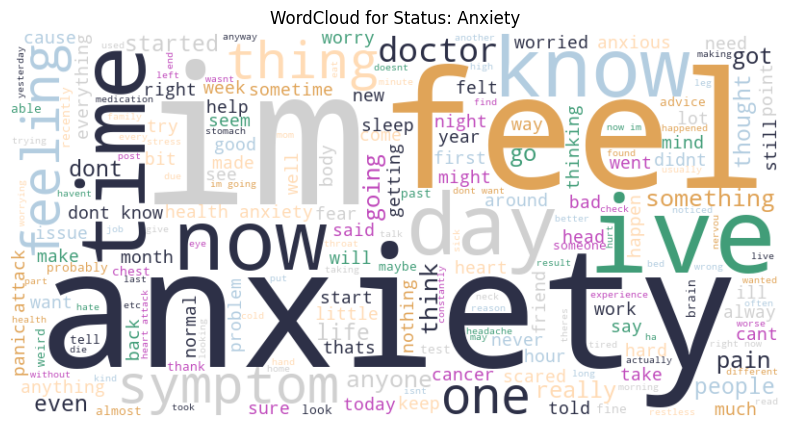

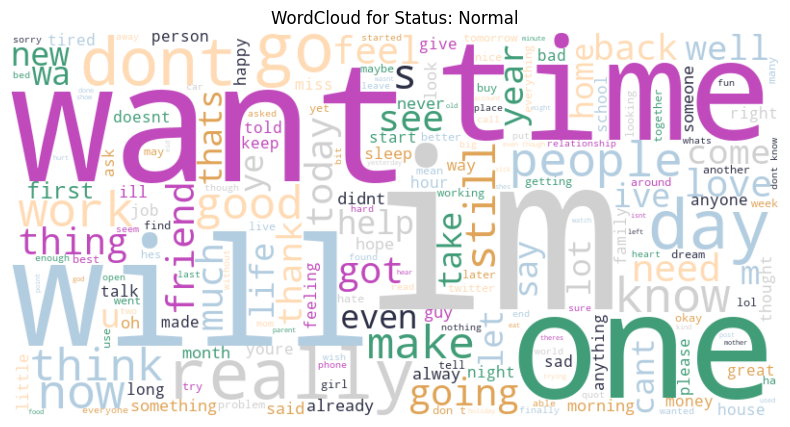

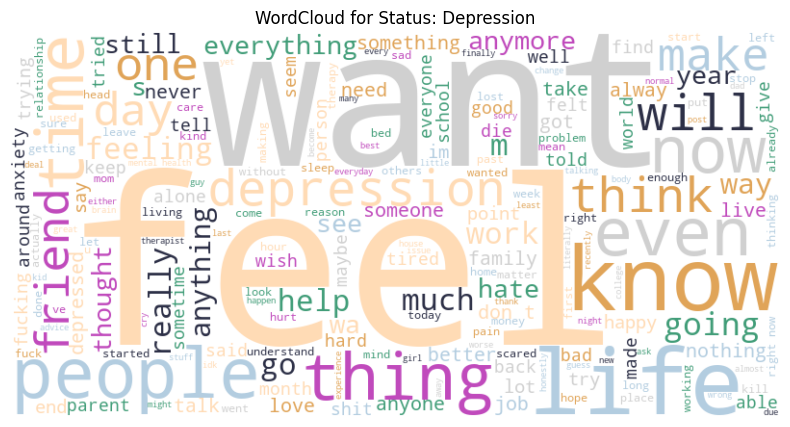

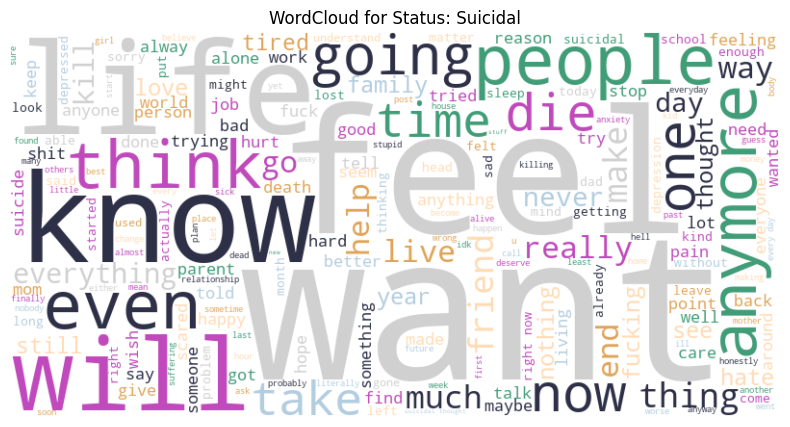

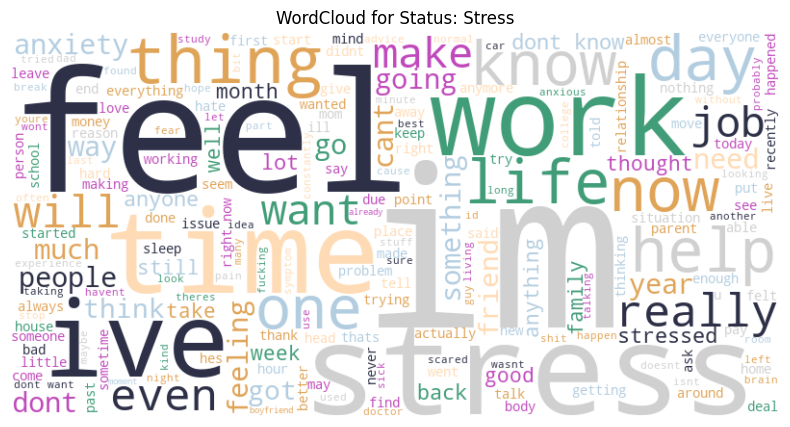

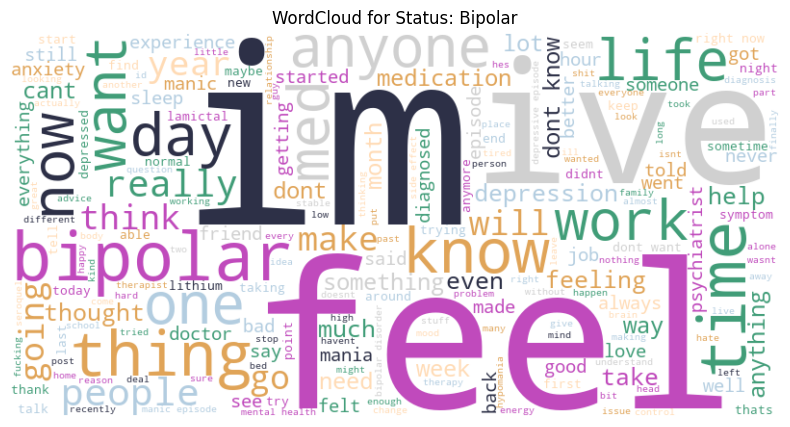

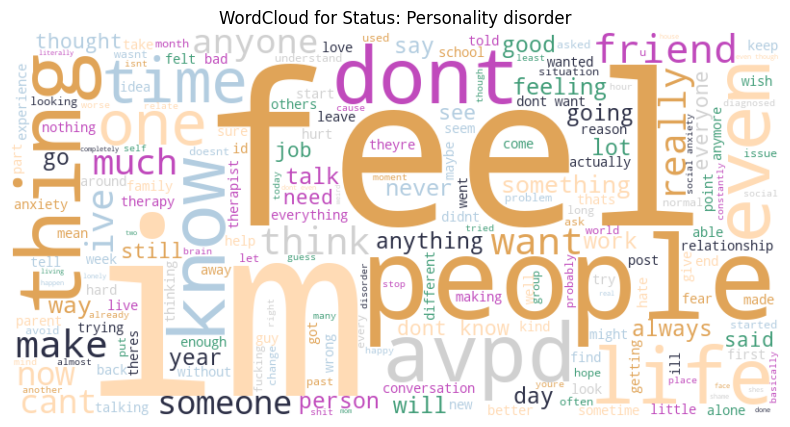

In [24]:
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(data[data['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

In [34]:
## save text processed data
data.to_csv('data_processed.csv')

## Data Preprocessing

In [ ]:
# data= pd.read_csv('data_processed.csv', index_col=0)

In [25]:
X = data[['tokens_lemmatized', 'num_of_characters', 'num_of_sentences']]
y = data['status']
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [26]:
#display unique values in y
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)


In [28]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack

# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_lemmatized'])
X_test_tfidf = vectorizer.transform(X_test['tokens_lemmatized'])

# 2. Extract and scale numerical features
scaler = StandardScaler()
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

X_train_num_scaled = scaler.fit_transform(X_train_num)  # Scale training numerical features
X_test_num_scaled = scaler.transform(X_test_num)       # Scale testing numerical features

# 3. Combine TF-IDF features with scaled numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num_scaled])  # Sparse matrix with combined features
X_test_combined = hstack([X_test_tfidf, X_test_num_scaled])

# 4. Print number of features in TF-IDF
print('Number of feature words: ', len(vectorizer.get_feature_names_out()))


Number of feature words:  50000


In [29]:
 #Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [40]:
# Define a dictionary of classifiers with their specific parameters.
# Note: The hyperparameters for these classifiers were chosen after performing GridSearchCV to optimize performance.
classifiers = {
    'Logistic Regression': LogisticRegression(solver='liblinear', penalty='l1', C=10, random_state=101),
    'XGB': XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=500, random_state=101, external_memory=True),
    'Bernoulli Naive Bayes': BernoulliNB(alpha=0.1, binarize=0.0),
    'Decision Tree': DecisionTreeClassifier(max_depth=9, min_samples_split=5, random_state=101)
}



For Logistic Regression
Accuracy: 0.7605580335959001
                      precision    recall  f1-score   support

             Anxiety       0.79      0.80      0.80       768
             Bipolar       0.82      0.79      0.80       566
          Depression       0.71      0.68      0.69      3050
              Normal       0.89      0.92      0.91      3237
Personality disorder       0.71      0.67      0.69       202
              Stress       0.58      0.61      0.59       530
            Suicidal       0.65      0.67      0.66      2184

            accuracy                           0.76     10537
           macro avg       0.74      0.73      0.73     10537
        weighted avg       0.76      0.76      0.76     10537



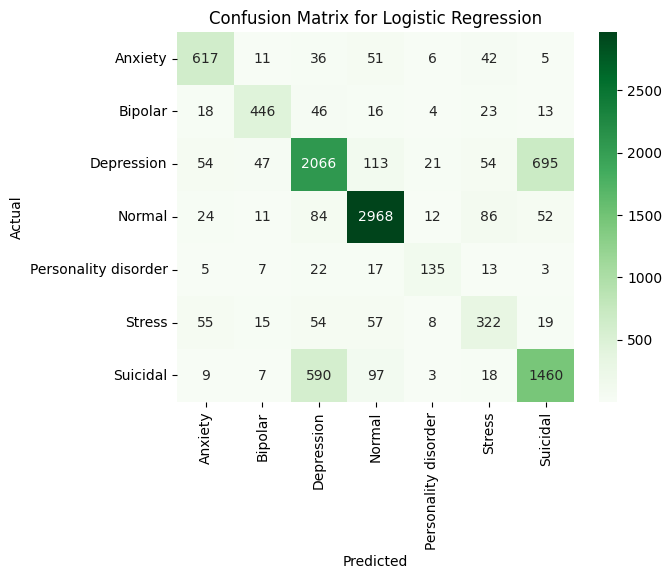

XGBoostError: [23:07:04] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\io.h:320: bad_malloc: Failed to allocate 1720371600 bytes.

In [41]:
# Initialize a list to store accuracy scores for each classifier
accuracy_scores = []

# Iterate over each classifier and its name in the classifiers dictionary
for name, clf in classifiers.items():
    clf.fit(X_train_resampled, y_train_resampled)
    y_pred = clf.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n")
    print("For", name)
    print("Accuracy:", accuracy)
    
    # Compute the confusion matrix for the predictions
    # 'lbl_enc.classes_' provides the class labels for the confusion matrix and classification report
    labels = lbl_enc.classes_
    conf_matrix = confusion_matrix(y_test, y_pred)
    print(classification_report(y_test, y_pred, target_names=labels))
    
    # Plot the confusion matrix using a heatmap
    # Annotate each cell with the numeric value of the confusion matrix
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')  # Label for x-axis
    plt.ylabel('Actual')     # Label for y-axis
    plt.title(f'Confusion Matrix for {name}')  # Title for the heatmap
    plt.show()  # Display the heatmap
    
    # Append the accuracy score to the list
    accuracy_scores.append(accuracy)


In [36]:
import torch

# Check if CUDA is available
print("CUDA Available:", torch.cuda.is_available())

# List all GPUs
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs: {num_gpus}")
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")


CUDA Available: False
Number of GPUs: 0
